In [1]:
# Agentic RAG
# Key thing to remenber - Agent Decides which VectorDB to refer
# Vector DBs needs to be converted to tools to be referred in Lanngraph Agentic workflow

# tool for doing Web Searcg
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]= os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"]= os.getenv("GOOGLE_API_KEY")

os.environ["LANGCHAIN_API_KEY"]= os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]= os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"]= os.getenv("LANGCHAIN_TRACING_V2")
os.environ["TAVILY_API_KEY"]= os.getenv("TAVILY_API_KEY")

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

modi_urls = [
    "https://www.thehindu.com/news/national/tamil-nadu/pm-modi-inaugurates-projects-in-tamil-nadu/article69857729.ece",
    "https://www.ndtv.com/india-news/narendra-modi-becomes-2nd-longest-serving-pm-in-india-surpasses-indira-gandhis-record-8945545",
    "https://www.hindustantimes.com/india-news/pm-narendra-modi-tops-democratic-leader-approval-ratings-donald-trump-not-in-top-5-survey-101753502888294.html",
    "https://en.wikipedia.org/wiki/Narendra_Modi"
]

India_us_deal_urls = [
    "https://timesofindia.indiatimes.com/business/india-business/india-us-trade-deal-piyush-goyal-shares-important-update-says-negotiations-making-fast-progress/articleshow/122923278.cms",
    "https://www.livemint.com/market/stock-market-news/stock-market-today-is-india-us-trade-deal-euphoria-ignoring-trumps-tariff-reality-11753506929046.html",
    "https://www.bbc.com/news/articles/c307ggj492vo"
]

docs_modi  = [WebBaseLoader(url).load() for url in modi_urls]
docs_ind_us = [WebBaseLoader(url).load() for url in India_us_deal_urls]


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [16]:
#docs_modi

In [6]:
# Text splitting 
docs_modi_list = [item for subdoc in docs_modi for item in subdoc]
docs_ind_us_deal_list = [item for subdoc in docs_ind_us for item in subdoc]

text_splitter1 = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 100)
docs_modi_splits = text_splitter1.split_documents(docs_modi_list)

text_splitter2 = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 100)
docs_ind_us_splits = text_splitter2.split_documents(docs_ind_us_deal_list)


In [18]:
#docs_modi_splits

In [9]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
embedding_dim = len(OpenAIEmbeddings().embed_query("test"))
index1 = faiss.IndexFlatIP(embedding_dim) # Exact Match(=Flat) , Euclidean Distance(=L2), [size of vector = 384)]
vectorstore_modi = FAISS(
    embedding_function = OpenAIEmbeddings(),
    index = index1,
    docstore = InMemoryDocstore(),
    index_to_docstore_id={}
)
vectorstore_modi.add_documents(docs_modi_splits)
retreiver_modi = vectorstore_modi.as_retriever()

In [13]:
index2 = faiss.IndexFlatIP(embedding_dim) # Exact Match(=Flat) , Euclidean Distance(=L2), [size of vector = 384)]
vectorstore_indus = FAISS(
    embedding_function = OpenAIEmbeddings(),
    index = index2,
    docstore = InMemoryDocstore(),
    index_to_docstore_id={}
)
vectorstore_indus.add_documents(docs_ind_us_splits)
retriever_indus = vectorstore_indus.as_retriever()

In [14]:
# Convert these retrievers into retriever tool 
# Remember LLM needs a docstring to decide what to search 
# Existing ways of creating vector do not have that
from langchain.tools.retriever import create_retriever_tool
retreiver_modi_tool = create_retriever_tool(
  retreiver_modi,
  "retreiever_modi_vectordb",
  "All recent news related to Narendra Modi and his latest tenure as Prime minister"
)

retreiver_indus_tool = create_retriever_tool(
  retriever_indus,
  "retriever_indus_vectordb",
  "All recent news related to India and US trade deals and discussions"
)

In [22]:
tools = [retreiver_modi_tool,retreiver_indus_tool]
# Define our LLM
from langchain_openai import ChatOpenAI


# Step1 - Create state for agent
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
    messages:Annotated[list,add_messages]

def agent(state:State):
    """
    It's job is to generate response based on the current state by invoking the right tool or agent models.
    Given a question , this will decide to retrieve using the retriever tool . Or simply end.

    Args:
        state : The current state
    
    Returns:
        dict : the updated state with agent response appended
    """
    print("--- Agent is called ----")
    messages = state["messages"]
    model = ChatOpenAI(model = "gpt-4o-mini")
    model = model.bind_tools(tools)
    response = model.invoke(messages)

    return {"messages":[response]}

def generate_response(state:State):
    """ 
    Generate answer
    Args:
        state(messages): The current state
    Returns: 
        dict: The updated message
    """
    print(" ---Generate Response---")
    messages = state["messages"]
    question = messages[0].content
    last_rel_message = messages[-1]
    docs = last_rel_message.content

    from langchain import hub
    prompt = hub.pull("rlm/rag-prompt")

    llm = ChatOpenAI(model = "gpt-4o-mini")

    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)
    
    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Invoke
    response = rag_chain.invoke({"context":docs,"question":question})
    return {"messages":[response]}





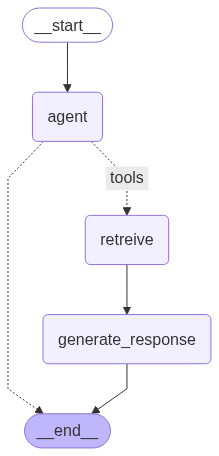

In [25]:
# Define a workflow

from langgraph.graph import START,StateGraph,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(State)
workflow.add_node("agent",agent)
retrieve = ToolNode([retreiver_modi_tool,retreiver_indus_tool])
workflow.add_node("retreive",retrieve)
workflow.add_node("generate_response",generate_response)

workflow.add_edge(START,"agent")
workflow.add_conditional_edges("agent",tools_condition,{"tools":"retreive",END:END,})
workflow.add_edge("retreive","generate_response")
workflow.add_edge("generate_response",END)

graph = workflow.compile()

from IPython.display import Image,display
display(Image(graph.get_graph(xray = True).draw_mermaid_png()))


In [ ]:
graph.invoke({"messages":"What are the latest updates on India US trade deal?"})

--- Agent is called ----
 ---Generate Response---


{'messages': [HumanMessage(content='What are the lates updates on India US trade deal?', additional_kwargs={}, response_metadata={}, id='b170a8d2-bf00-48a7-8234-1f2042204a2d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PniGZ3f3BW8J572EquTasMZF', 'function': {'arguments': '{"query":"latest updates on India US trade deal"}', 'name': 'retriever_indus_vectordb'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 120, 'total_tokens': 146, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BxnH7wWP09Ofwl4b34bG5OuYXJN3M', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ddbf9e6b-4f37-4a8f-8943-05f926d0d8f9-0', tool_c

In [27]:
from pprint import pprint
messages = graph.invoke({"messages":"What are the latest updates on India US trade deal?"})
for m in messages['messages']:
    m.pretty_print()

--- Agent is called ----
 ---Generate Response---
================================ Human Message =================================

What are the latest updates on India US trade deal?
================================== Ai Message ==================================
Tool Calls:
  retriever_indus_vectordb (call_tsNALBd9HjIehRNQkx210jQs)
 Call ID: call_tsNALBd9HjIehRNQkx210jQs
  Args:
    query: India US trade deal
================================= Tool Message =================================
Name: retriever_indus_vectordb

on the proposed bilateral trade agreement are progressing swiftly.Addressing the media, Goyal said that negotiations with Washington are “making fast progress”, as per news agency PTI.India-U.S. Trade Deal: What's India's Smart Backup Plan If The Deal Falls Through? | ExplainedA team from the US is scheduled to visit India in August for the next round of negotiations.The fifth round of talks between the two countries concluded last week in Washington. Both sides are n

In [28]:
from pprint import pprint
messages = graph.invoke({"messages":"How is Narenda Modi's latest tenure?"})
for m in messages['messages']:
    m.pretty_print()

--- Agent is called ----
 ---Generate Response---
================================ Human Message =================================

How is Narenda Modi's latest tenure?
================================== Ai Message ==================================
Tool Calls:
  retreiever_modi_vectordb (call_nIsKSZV5bQZWqpXpejgTcR4O)
 Call ID: call_nIsKSZV5bQZWqpXpejgTcR4O
  Args:
    query: Narendra Modi latest tenure
================================= Tool Message =================================
Name: retreiever_modi_vectordb

Prime Minister of India (2014–present)
Main article: Premiership of Narendra Modi
For a chronological guide, see Timeline of the premiership of Narendra Modi.
Modi taking the oath of office as the Prime Minister of India for the first time, with President Pranab Mukherjee administering the oath
Modi taking the oath of office as the Prime Minister of India for the second time, with President Ram Nath Kovind administering the oath
Modi taking the oath of office as the Prime Mi

In [29]:
from pprint import pprint
messages = graph.invoke({"messages":"What is Agentic RAG?"})
for m in messages['messages']:
    m.pretty_print()

--- Agent is called ----
================================ Human Message =================================

What is Agentic RAG?
================================== Ai Message ==================================

Agentic RAG (Retrieval-Augmented Generation) combines retrieval-based methods with generative models to enhance the performance of language models in various applications. This approach allows models to access and incorporate external information dynamically, boosting their ability to generate coherent and contextually relevant responses. 

Key features of Agentic RAG include:

1. **Retrieval Mechanism**: It retrieves relevant documents or data from a large dataset or knowledge base during the generation process, ensuring the model has access to accurate and up-to-date information.

2. **Augmented Generation**: The retrieved information is used to augment the generative capabilities of the model. This means the model doesn't just rely on its training data but can adapt based on n